In [15]:
from pyearth import Earth
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely import geometry
from osgeo import gdal
import autosklearn.classification
import sklearn.model_selection
import tpot
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Open data

In [2]:
ref=gdal.Open('/mnt/g/TOPSOIL/Clay_eu23.tif')
data=pd.read_excel('/mnt/g/TOPSOIL/LUCAS_TOPSOIL_v1.xlsx')
sum0=(data.silt==0)*1+(data.clay==0)*1+(data.sand==0)*1
sum0[sum0==3]=None

In [3]:
data['SUM']=sum0
data=data.dropna(subset=['SUM','GPS_LONG', 'GPS_LAT'])
cmap = 'Spectral_r'

In [4]:
data['geometry']=[geometry.Point(x, y) for x, y in zip(data['GPS_LONG'], data['GPS_LAT'])]
data = gpd.GeoDataFrame(data, geometry='geometry', crs= 'EPSG:4326')
data.head()
data= data.to_crs(ref.GetProjectionRef())
data['xproj']=[d.x for d in data.geometry]
data['yproj']=[d.y for d in data.geometry]

In [5]:
Clay=data['clay']
Sand=data['sand']
Silt=data['silt']

In [6]:
def alr(clay,sand,silt):
    alr1=np.log(clay/sand)
    alr2=np.log(silt/sand)
    return np.column_stack((alr1,alr2))

In [7]:
ALR=alr(Clay,Sand,Silt)

/home/geoffreybess/.local/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Define grid

In [8]:
pixel_size = 500
x_range = np.arange(data.xproj.min()-data.xproj.min() % pixel_size,
                    data.xproj.max(), pixel_size)
y_range = np.arange(data.yproj.min()-data.yproj.min() % pixel_size,
                    data.yproj.max(), pixel_size)[::-1]

In [9]:
vmin = 0
vmax = 100

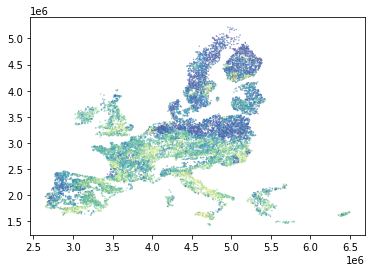

In [10]:
plt.scatter(data.xproj, data.yproj, cmap=cmap, s=0.1, c=Clay, vmin=vmin, vmax=vmax)

In [11]:
shape = (len(y_range), len(x_range))
extent = xmin, xmax, ymin, ymax = x_range.min(), x_range.max(), y_range.min(), y_range.max()
x_mesh, y_mesh= np.meshgrid(x_range, y_range)

In [12]:
data.loc[:, 'X_INDEX'] = np.floor(((data.xproj - xmin) / pixel_size)).astype(int)
data.loc[:, 'Y_INDEX'] = np.floor(shape[0] - ((data.yproj - ymin) / pixel_size)).astype(int)
data_array = np.zeros(shape)
data_array[:] = np.nan
data_array[data.Y_INDEX, data.X_INDEX] = Clay

In [13]:
y_fit = data_array[np.isfinite(data_array)]
x_index_fit, y_index_fit = np.where(np.isfinite(data_array))
x_index_pred, y_index_pred = np.where(data_array)

X_fit = MinMaxScaler().fit_transform(np.vstack([x_index_fit, y_index_fit]).T)
X_pred = MinMaxScaler().fit_transform(np.vstack([x_index_pred, y_index_pred]).T)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_fit, y_fit,
                                                    train_size=0.75, test_size=0.25, random_state=42)

treg = tpot.TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42)
treg.fit(X_train, y_train)
print(treg.score(X_test, y_test))
treg.export('tpot_clay_test.py')

Generation 1 - Current best internal CV score: -91.38310574884352
Generation 2 - Current best internal CV score: -91.38310574884352
Generation 3 - Current best internal CV score: -91.38310574884352
Generation 4 - Current best internal CV score: -91.38310574884352
Generation 5 - Current best internal CV score: -91.38310574884352

Best pipeline: KNeighborsRegressor(input_matrix, n_neighbors=18, p=2, weights=distance)
-89.15159192842546


In [23]:
tpot_pred = treg.predict(X_pred)
tpot_pred_reshaped = np.zeros(shape)
tpot_pred_reshaped[:] = np.nan
for i,_ in enumerate(tpot_pred):
    tpot_pred_reshaped[x_index_pred[i],y_index_pred[i]]=tpot_pred[i]

In [24]:
tpot_pred_reshaped

array([[10.50228031, 10.50227547, 10.50227061, ...,  3.05658681,
         3.05658907,  3.05659133],
       [10.50230567, 10.50230083, 10.50229599, ...,  3.05659151,
         3.05659377,  3.05659603],
       [10.50233105, 10.50232622, 10.50232138, ...,  3.05659621,
         3.05659847,  3.05660071],
       ...,
       [27.37878242, 27.37827384, 27.37776307, ..., 25.02141747,
        24.21424057, 24.21412692],
       [27.37852278, 27.37801452, 27.37750408, ..., 25.02144601,
        24.21416456, 24.21405149],
       [27.37826482, 27.37775688, 27.37724676, ..., 25.0214742 ,
        25.02134634, 24.21397625]])

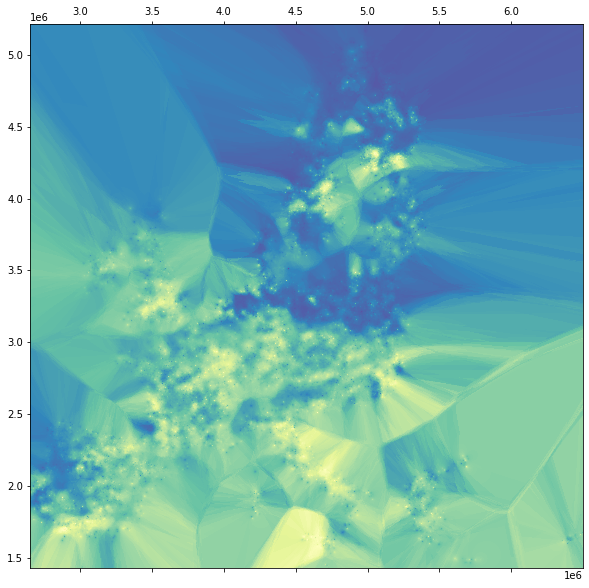

In [26]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
ax.matshow(tpot_pred_reshaped, extent=extent, cmap=cmap, vmin=vmin, vmax=vmax)
#ax.scatter(data.xproj, data.yproj, cmap=cmap, c=Clay, vmin=vmin, vmax=vmax,linewidths=1, edgecolors='k')
